# **Kaggle Plant Pathology Classification with Xception Model**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import shutil
import cv2
import numpy as np

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, MaxPooling2D, Flatten, BatchNormalization, GaussianNoise, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd,numpy as np,pylab as pl

%matplotlib inline

In [0]:
#### Trainings DATAFRAME #########

from IPython.display import Image
data_dir = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/'
training_images = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/images/'

traindf=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Plant Pathology/train.csv', dtype=str)

traindf['healthy'] = traindf['healthy'].astype(str)
traindf['multiple_diseases'] = traindf['multiple_diseases'].astype(str)
traindf['rust'] = traindf['rust'].astype(str)
traindf['scab'] = traindf['scab'].astype(str)

def append_ext(fn):
    return fn+".jpg"
traindf["image_id"]=traindf["image_id"].apply(append_ext)

## **Data preprocessing**

In [11]:
#### DATA PREPROZESSING ####

image_size = 224 # All images will be resized to 224x224
batch_size = 32

train_datagen_I = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.25
)
validation_datagen_I=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
train_generator_I = train_datagen_I.flow_from_dataframe(dataframe=traindf, directory=training_images,
                                             x_col='image_id',
                                             y_col=['healthy','multiple_diseases','rust','scab'],
                                             target_size=(image_size, image_size),
                                             batch_size=batch_size,
                                             class_mode='raw',
                                             subset='training',
                                             shuffle=True,
                                             seed=7)
validation_generator_I = validation_datagen_I.flow_from_dataframe(dataframe=traindf, directory=training_images,
                                             x_col='image_id',
                                             y_col=['healthy','multiple_diseases','rust','scab'],
                                             target_size=(image_size, image_size),
                                             class_mode='raw',
                                             batch_size=batch_size,
                                             shuffle=True,
                                             subset='validation',
                                             seed=7)

Found 1366 validated image filenames.
Found 455 validated image filenames.


### **Show images (optional)**

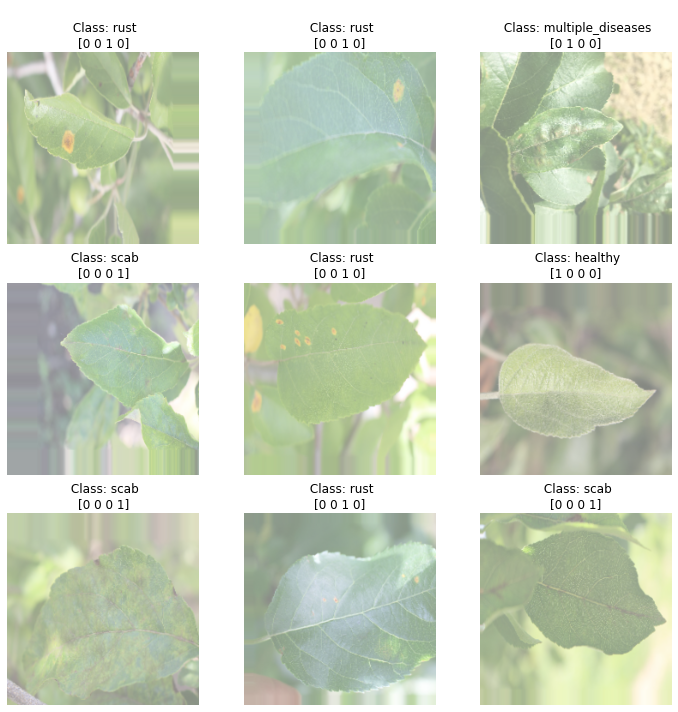

In [12]:
####   SHOW AUGMENTED IMAGES   ####

import typing
def plot_images_with_labels(
    images: typing.List[int], labels: np.ndarray, class_names: typing.List[str]) -> None:
    if len(images) != 9:
        images = images[:9]
        labels = labels[:9]
    labels = labels.astype(int)

    plt.figure(figsize=(12, 12))
    index = 0
    for image, label in zip(images, labels):
        index += 1
        plt.subplot(3, 3, index)
        plt.imshow(image)
        plt.title("\n Class: " + format(class_names[label.argmax()]) + "\n" + format(label))
        plt.axis("off")

# plot some augmented images
X_augmented, y_augmented = next(train_generator_I)
plot_images_with_labels((X_augmented + 1) / 2, y_augmented, ['healthy','multiple_diseases','rust','scab'])

## **Transfer learning model with Xception pre-train model and a new Fully-Connected-Classifier**
*   ### with fine-tuning
*   ### with data augmentation
*   ### Optimizer RMSprop(lr=0.0001)

In [0]:
####    BILD THE MODEL WITH XCEPTION AND RMSprop OPTIMIZER ####

n_classes = 4
# build a transfer learning model with Xception and a new Fully-Connected-Classifier
base_model = Xception(
    weights='imagenet',
    include_top=False
)
for layer in base_model.layers:
  layer.trainable = True

model = GlobalAveragePooling2D()(base_model.output)
model = Dropout(0.5)(model)

# include new Fully-Connected-Classifier
output_layer = Dense(n_classes, activation='softmax')(model)

# create Model
model = Model(base_model.input, output_layer)


### Fit the model

In [14]:
# Saving the model
# Directory where the checkpoints will be saved
checkpoint_dir = data_dir + 'training_checkpoints'
#os.makedirs(checkpoint_dir, exist_ok = True)
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_training_xception_accuracy")


checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
steps_per_epoch = train_generator_I.n // batch_size
validation_steps = validation_generator_I.n // batch_size
print(steps_per_epoch)
historyI = model.fit_generator(train_generator_I,
                              steps_per_epoch = steps_per_epoch,
                              epochs=25,
                              validation_data=validation_generator_I,
                              callbacks=[checkpoint_callback])

42
Epoch 1/25
42/42 [==============================] - 567s 14s/step - loss: 0.7331 - acc: 0.7481 - val_loss: 0.9360 - val_acc: 0.7319
Epoch 2/25
42/42 [==============================] - 79s 2s/step - loss: 0.3256 - acc: 0.9010 - val_loss: 0.7421 - val_acc: 0.8022
Epoch 3/25
42/42 [==============================] - 78s 2s/step - loss: 0.2695 - acc: 0.9115 - val_loss: 0.5164 - val_acc: 0.8637
Epoch 4/25
42/42 [==============================] - 78s 2s/step - loss: 0.1761 - acc: 0.9453 - val_loss: 0.4971 - val_acc: 0.8813
Epoch 5/25
42/42 [==============================] - 78s 2s/step - loss: 0.1469 - acc: 0.9528 - val_loss: 0.5229 - val_acc: 0.8879
Epoch 6/25
42/42 [==============================] - 78s 2s/step - loss: 0.1212 - acc: 0.9573 - val_loss: 0.4164 - val_acc: 0.9165
Epoch 7/25
42/42 [==============================] - 78s 2s/step - loss: 0.0883 - acc: 0.9693 - val_loss: 0.4073 - val_acc: 0.9143
Epoch 8/25
42/42 [==============================] - 77s 2s/step - loss: 0.0573 - acc:

In [15]:
#### DATA PREDICTION ####
data_dir = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/'
test_images = '/content/drive/My Drive/Colab Notebooks/Plant Pathology/images/'
#display(Image(training_images + '14.png'))
#display(Image(training_images + 'Test_0.jpg'))
testdf=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Plant Pathology/test.csv', dtype=str)
def append_ext(fn):
    return fn+".jpg"
testdf["image_id"]=testdf["image_id"].apply(append_ext)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
image_size = 224 # All images will be resized to 224x224
batch_size = 1

test_generator = test_datagen.flow_from_dataframe(dataframe=testdf, directory=test_images,
                                             x_col='image_id',
                                             target_size=(image_size, image_size),
                                             batch_size=batch_size,
                                             class_mode=None,
                                             shuffle=False)


filenames = test_generator.filenames
nb_samples = len(filenames)

steps = test_generator.n // batch_size

predict = model.predict_generator(test_generator, 100)
#np.savetxt(data_dir + "predict_test.csv", predict, fmt="%10.3f")
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print("Accuracy = ", predict)


Found 1821 validated image filenames.
Accuracy =  [[0.000 0.000 1.000 0.000]
 [0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000]
 [1.000 0.000 0.000 0.000]
 [0.000 0.000 1.000 0.000]
 [0.588 0.000 0.306 0.106]
 [1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 1.000]
 [0.000 0.739 0.000 0.261]
 [0.000 0.000 1.000 0.000]
 [0.000 0.000 1.000 0.000]
 [0.965 0.000 0.035 0.000]
 [0.000 0.003 0.000 0.997]
 [1.000 0.000 0.000 0.000]
 [0.000 0.001 0.999 0.000]
 [0.000 0.000 1.000 0.000]
 [1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.999]
 [0.048 0.020 0.013 0.919]
 [0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000]
 [1.000 0.000 0.000 0.000]
 [0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000]
 [1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 1.000]
 [0.000 0.000 0.002 0.997]
 [0.000 0.000 1.000 0.000]
 [1.000 0.000 0.000 0.000]
 [0.005 0.418 0.537 0.039]
 [0.999 0.000 0.000 0.001]
 [0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000]
 [0.000 0.000 0.000 1.000]
 [0.000 0.000 0.000 1.000]
 [0.0

In [0]:
def plot_learning_curve(
    title: str, x: int, y: int, y_test: int, ylim: float = 0.6
) -> None:
    plt.figure()
    plt.title(title)
    axes = plt.gca()
    axes.set_ylim([ylim, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    train_sizes = x
    train_scores = y
    test_scores = y_test

    plt.grid()

    plt.plot(
        train_sizes,
        train_scores,
        "o-",
        color=(177 / 255, 6 / 255, 58 / 255),
        label="Training accuracy",
    )
    plt.plot(
        train_sizes,
        test_scores,
        "o-",
        color=(246 / 255, 168 / 255, 0),
        label="Validation accuracy",
    )

    plt.legend(loc="best")


def plot_history(title: str, history: "History", ylim: float = 0.6) -> None:
    y = history.history["acc"]
    y_test = history.history["val_acc"]
    plot_learning_curve(title, np.arange(1, 1 + len(y)), y, y_test, ylim)



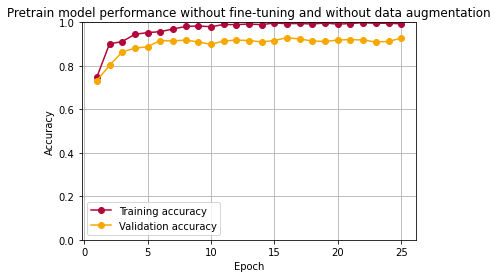

In [17]:
plot_history('Performance with fine-tuning and data augmentation', historyI, 0)
#plot_history('Pretrain model performance with fine-tuning with data augmentation', historyII, 0)
#plot_history('Pretrain model performance with fine-tuning without data augmentation', historyIII, 0)

## Summary
### I chose Xception as my pre-trained model. Without fine-tuning, the results were not at all satisfactory - accuracy about 0.5. It didn't matter which optimizer I used or how the learning rate was set.
### The breakthrough came through fine-tuning. The RMSprop Optimizer was able to achieve better results than Adam or SGD - Accuracy 0.92-0.93